<a href="https://colab.research.google.com/github/amanichopra/understanding-deep-learning-textbook-exercises/blob/main/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-b2s98sxj
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-b2s98sxj
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14665 sha256=580eef2cd09035e4d72b27bf2dc828c9059d8feacbc5e7f2b121e6f2c9181223
  Stored in directory: /tmp/pip-ephem-wheel-cache-3p4gxlzf/wheels/18/40/b6/29381fee9b4c80fdbc304d52bb065a7286bbcca5ca2b8737c0
Successfully built mnist1d


In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [5]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [3]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TODO:
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
model = torch.nn.Sequential(torch.nn.Linear(D_i, D_k),
                            torch.nn.ReLU(),
                            torch.nn.Linear(D_k, D_k),
                            torch.nn.ReLU(),
                            torch.nn.Linear(D_k, D_o));


def weights_init(layer_in):
  # TODO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  print("Initializing layer")
  if isinstance(layer_in, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(layer_in.weight.data, nonlinearity='relu')
        if layer_in.bias is not None:
            torch.nn.init.zeros_(layer_in.bias.data)


# Call the function you just defined
model.apply(weights_init)


Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [6]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Epoch     0, train loss 1.611675, train error 61.60,  test loss 1.698589, test error 68.50
Epoch     1, train loss 1.380039, train error 50.33,  test loss 1.551344, test error 62.50
Epoch     2, train loss 1.190399, train error 42.85,  test loss 1.398823, test error 54.60
Epoch     3, train loss 1.022725, train error 36.92,  test loss 1.283892, test error 48.60
Epoch     4, train loss 0.943813, train error 34.00,  test loss 1.257002, test error 48.80
Epoch     5, train loss 0.813583, train error 28.25,  test loss 1.189709, test error 45.00
Epoch     6, train loss 0.725803, train error 24.88,  test loss 1.134761, test error 42.90
Epoch     7, train loss 0.659079, train error 23.07,  test loss 1.133906, test error 42.50
Epoch     8, train loss 0.616265, train error 22.22,  test loss 1.188110, test error 43.60
Epoch     9, train loss 0.536963, train error 18.32,  test loss 1.1

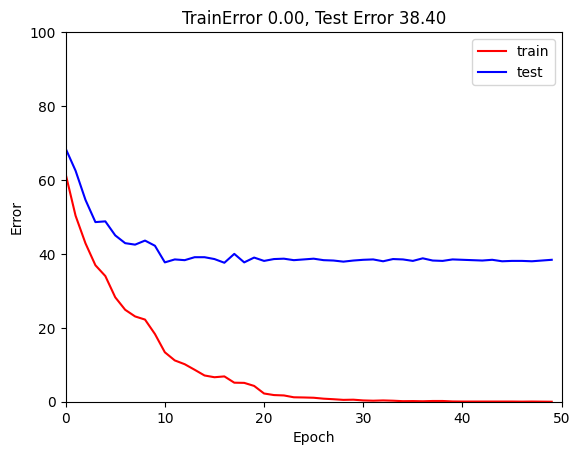

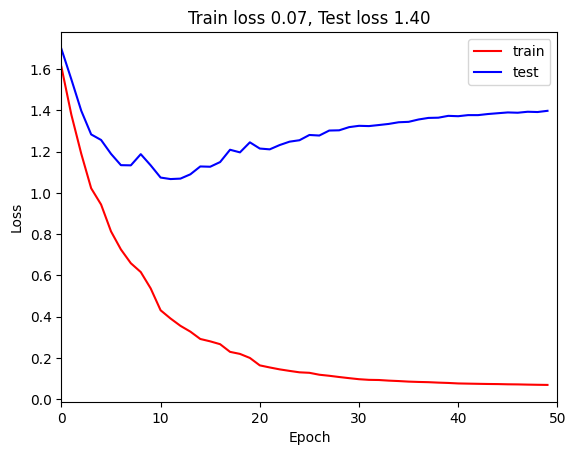

In [7]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TODO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

More epochs to see if model groks.

In [ ]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 1440
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

In [10]:
import plotly.graph_objects as go

# ----- Plot Errors -----
fig_errors = go.Figure()

fig_errors.add_trace(go.Scatter(
    y=errors_train,
    mode='lines',
    name='Train',
    line=dict(color='red')
))
fig_errors.add_trace(go.Scatter(
    y=errors_test,
    mode='lines',
    name='Test',
    line=dict(color='blue')
))

fig_errors.update_layout(
    title=f"Train Error {errors_train[-1]:.2f}, Test Error {errors_test[-1]:.2f}",
    xaxis=dict(title="Epoch", range=[0, n_epoch]),
    yaxis=dict(title="Error", range=[0, 100]),
    legend=dict(x=0.8, y=0.95)
)

fig_errors.show()


# ----- Plot Losses -----
fig_losses = go.Figure()

fig_losses.add_trace(go.Scatter(
    y=losses_train,
    mode='lines',
    name='Train',
    line=dict(color='red')
))
fig_losses.add_trace(go.Scatter(
    y=losses_test,
    mode='lines',
    name='Test',
    line=dict(color='blue')
))

fig_losses.update_layout(
    title=f"Train Loss {losses_train[-1]:.2f}, Test Loss {losses_test[-1]:.2f}",
    xaxis=dict(title="Epoch", range=[0, n_epoch]),
    yaxis=dict(title="Loss"),
    legend=dict(x=0.8, y=0.95)
)

fig_losses.show()


Batch size 100

In [11]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=1000, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Epoch     0, train loss 2.403368, train error 82.85,  test loss 2.466396, test error 85.60
Epoch     1, train loss 2.020764, train error 75.20,  test loss 2.094005, test error 80.40
Epoch     2, train loss 1.875894, train error 70.97,  test loss 1.960125, test error 77.70
Epoch     3, train loss 1.760746, train error 68.57,  test loss 1.853248, test error 75.40
Epoch     4, train loss 1.690067, train error 66.03,  test loss 1.778060, test error 73.40
Epoch     5, train loss 1.633632, train error 63.38,  test loss 1.727213, test error 71.10
Epoch     6, train loss 1.598327, train error 62.22,  test loss 1.690962, test error 69.30
Epoch     7, train loss 1.559850, train error 60.15,  test loss 1.658568, test error 67.80
Epoch     8, train loss 1.526994, train error 58.47,  test loss 1.641295, test error 68.20
Epoch     9, train loss 1.492746, train error 55.78,  test loss 1.6

In [12]:
# ----- Plot Errors -----
fig_errors = go.Figure()

fig_errors.add_trace(go.Scatter(
    y=errors_train,
    mode='lines',
    name='Train',
    line=dict(color='red')
))
fig_errors.add_trace(go.Scatter(
    y=errors_test,
    mode='lines',
    name='Test',
    line=dict(color='blue')
))

fig_errors.update_layout(
    title=f"Train Error {errors_train[-1]:.2f}, Test Error {errors_test[-1]:.2f}",
    xaxis=dict(title="Epoch", range=[0, n_epoch]),
    yaxis=dict(title="Error", range=[0, 100]),
    legend=dict(x=0.8, y=0.95)
)

fig_errors.show()


# ----- Plot Losses -----
fig_losses = go.Figure()

fig_losses.add_trace(go.Scatter(
    y=losses_train,
    mode='lines',
    name='Train',
    line=dict(color='red')
))
fig_losses.add_trace(go.Scatter(
    y=losses_test,
    mode='lines',
    name='Test',
    line=dict(color='blue')
))

fig_losses.update_layout(
    title=f"Train Loss {losses_train[-1]:.2f}, Test Loss {losses_test[-1]:.2f}",
    xaxis=dict(title="Epoch", range=[0, n_epoch]),
    yaxis=dict(title="Loss"),
    legend=dict(x=0.8, y=0.95)
)

fig_losses.show()


Adam opt

In [14]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=1000, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Epoch     0, train loss 2.048072, train error 78.15,  test loss 2.082701, test error 78.70
Epoch     1, train loss 1.792731, train error 72.20,  test loss 1.864398, test error 74.40
Epoch     2, train loss 1.659250, train error 63.78,  test loss 1.737846, test error 67.20
Epoch     3, train loss 1.570684, train error 59.95,  test loss 1.673232, test error 67.30
Epoch     4, train loss 1.481511, train error 56.53,  test loss 1.628575, test error 64.10
Epoch     5, train loss 1.400237, train error 51.72,  test loss 1.572873, test error 61.80
Epoch     6, train loss 1.317761, train error 49.28,  test loss 1.509710, test error 59.00
Epoch     7, train loss 1.236021, train error 44.47,  test loss 1.456743, test error 54.90
Epoch     8, train loss 1.162354, train error 41.35,  test loss 1.392394, test error 54.50
Epoch     9, train loss 1.090082, train error 38.22,  test loss 1.3

In [15]:
# ----- Plot Errors -----
fig_errors = go.Figure()

fig_errors.add_trace(go.Scatter(
    y=errors_train,
    mode='lines',
    name='Train',
    line=dict(color='red')
))
fig_errors.add_trace(go.Scatter(
    y=errors_test,
    mode='lines',
    name='Test',
    line=dict(color='blue')
))

fig_errors.update_layout(
    title=f"Train Error {errors_train[-1]:.2f}, Test Error {errors_test[-1]:.2f}",
    xaxis=dict(title="Epoch", range=[0, n_epoch]),
    yaxis=dict(title="Error", range=[0, 100]),
    legend=dict(x=0.8, y=0.95)
)

fig_errors.show()


# ----- Plot Losses -----
fig_losses = go.Figure()

fig_losses.add_trace(go.Scatter(
    y=losses_train,
    mode='lines',
    name='Train',
    line=dict(color='red')
))
fig_losses.add_trace(go.Scatter(
    y=losses_test,
    mode='lines',
    name='Test',
    line=dict(color='blue')
))

fig_losses.update_layout(
    title=f"Train Loss {losses_train[-1]:.2f}, Test Loss {losses_test[-1]:.2f}",
    xaxis=dict(title="Epoch", range=[0, n_epoch]),
    yaxis=dict(title="Loss"),
    legend=dict(x=0.8, y=0.95)
)

fig_losses.show()
